In [34]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.


import numpy as np
import pandas as pd
import csss
import sqlalchemy as sq
import matplotlib.pyplot as plt
import matplotlib
import pytz
import datetime as dt
import pickle as pk
from imp import reload
import copy
import seaborn as sns


% matplotlib notebook

## Load Sensitivity Analysis of Training Problem
This table is output in the notebook "Solar Disaggregation Sensitivity"
Correct for a couple things:
- Add an ''issolar'' column
- Bin the fraction of time spent in reverse power flow. 
- Absolute value the CV calculation (whoops)
- Correct the fact that the Nprox variable is not written to aggregate load fits. 

In [35]:
scenario_df = pd.read_csv('data/ScenarioAttmempt9.csv')
scenario_df['frac_reverse_bin'] = pd.cut(scenario_df['frac_reverse'],np.arange(0,.4, step = .025))
scenario_df['cv'] = np.abs(scenario_df['cv_pos']) #* np.sqrt(3) / 3
scenario_df['issolar'] = (scenario_df['models'] != 'AggregateLoad') & (scenario_df['mean'] < 0)


## Correct for the N_prox column for aggregate load. 
correct_prox = scenario_df[['scen_name','N_prox']][scenario_df['N_prox']>0].drop_duplicates()
correct_prox.columns = ['scen_name','N_prox_corrected']
scenario_df = scenario_df.merge(correct_prox)
#scenario_df[['rmse','cv','mean','rmse_pos','cv_pos','mean_pos']].head(20)

## Make Figures for Sensitivity Analysis
These all follow the same boxplot form. They appear small 

In [36]:
## Set some default figure properties. 
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 8}


matplotlib.rc('font', **font)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('font' ,size = 8)
plt.rc('axes',labelsize=7, facecolor = 'white', grid = True, linewidth = 0.5, edgecolor = 'black')
plt.rc('grid',lw=.25, color = 'grey')
plt.rc('figure',dpi = 128)

<IPython.core.display.Javascript object>


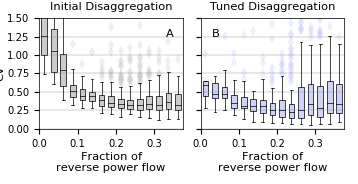

In [37]:
fig = plt.figure(figsize = (3.5,1.8))

tunecolor = '#CCCCFF'
initcolor = '#CCCCCC'
col_name = 'frac_reverse_bin'


### Systems with Solar
ind_sol = ((scenario_df['N_prox'] == 3) & 
       (scenario_df['N_tunesys'] == 2) & 
       (scenario_df['N_read'] == 960) & 
       (scenario_df['issolar'] == True) & 
       (scenario_df['N_sys'] == 8) )

ax  = plt.axes([.11, .3, .40, .6])
boxcol = initcolor
plt_scen = scenario_df.loc[ind_sol,:].groupby('tuned').get_group(False)
#plt_scen = plt_scen.loc[plt_scen['issolar'],:]
#plt_scen = plt_scen.loc[plt_scen['frac_reverse'] > -1,:]
sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
            medianprops={'color':'black','linewidth':.5},
            whiskerprops={'color':'black', 'linewidth':.5},
            boxprops={'edgecolor':'black', 'linewidth':.5},
            capprops={'color':'black', 'linewidth': .5},
            flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
           )
ax.set_ylim(0,1.5)
ax.set_xticks(ax.get_xticks()[::4]-.5)
ax.set_xticklabels(np.arange(0,.4, step = .025)[::4], fontsize = 7)
ax.set_xlabel('Fraction of\nreverse power flow', labelpad = 2, size = 8)
ax.set_ylabel('CV', labelpad = 1, size = 8)
ax.set_title('Initial Disaggregation', fontsize = 8)
ax.grid(axis = 'y', zorder = 0, linewidth = .25)
ax.annotate('A', (.88, .83) , xycoords=ax.transAxes, fontsize=8)



ax  = plt.axes([.56, .3, .40, .6])
plt_scen = scenario_df.loc[ind_sol,:].groupby('tuned').get_group(True)
boxcol = tunecolor
#plt_scen = plt_sceAn.loc[plt_scen['issolar'],:]
#plt_scen = plt_scen.loc[plt_scen['frac_reverse'] > -1,:]
sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
            medianprops={'color':'black','linewidth':.5},
            whiskerprops={'color':'black', 'linewidth':.5},
            boxprops={'edgecolor':'black', 'linewidth':.5},
            capprops={'color':'black', 'linewidth': .5},
            flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
           )
ax.set_ylim(0,1.5)
ax.set_xticks(ax.get_xticks()[::4]-.5)
ax.set_xticklabels(np.arange(0,.4, step = .025)[::4], fontsize = 7)
ax.set_yticklabels([''] * len(ax.get_yticks()))
ax.set_xlabel('Fraction of\nreverse power flow', labelpad = 2, size = 8)
ax.set_ylabel('')
#ax.set_xlabel('Fraction of Reverse Power Flow')
ax.set_title('Tuned Disaggregation', fontsize = 8)
ax.grid(axis = 'y', zorder = 0, linewidth = .25)
ax.annotate('B', (.08, .83) , xycoords=ax.transAxes, fontsize=8)


fig.savefig('figures/sens_revpf_v2.pdf')

In [38]:
def sens_boxplotfig(scen_name, col_name, x_label, fig = None):

    if fig is None:
        fig = plt.figure(figsize = (3.5,3.5))
    
    tunecolor = '#CCCCFF'
    initcolor = '#CCCCCC'
    
    ### Systems with Solar
    ind_sol = (([scen_name in n for n in scenario_df['scen_name']]) & 
           (scenario_df['issolar'] == True))

    ax  = plt.axes([.10, .69, .40, .25])
    boxcol = initcolor
    plt_scen = scenario_df.loc[ind_sol,:].groupby('tuned').get_group(False)
    #plt_scen = plt_scen.loc[plt_scen['issolar'],:]
    #plt_scen = plt_scen.loc[plt_scen['frac_reverse'] > -1,:]
    sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5},
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
               )
    ax.set_ylim(0,1.5)
    ax.set_xticklabels([''] * len(ax.get_xticks()))
    plt.xticks(rotation = 90)
    #ax.set_xlabel('Fraction of Reverse Power Flow')
    ax.set_xlabel('')
    ax.set_ylabel('CV', labelpad = 1)
    ax.set_title('Initial Disaggregation', fontsize = 8)
    ax.grid(axis = 'y', zorder = 0, linewidth = .25)
    ax.annotate('A', (.08, .83) , xycoords=ax.transAxes, fontsize=8)



    ax  = plt.axes([.52, .69, .40, .25])
    plt_scen = scenario_df.loc[ind_sol,:].groupby('tuned').get_group(True)
    boxcol = tunecolor
    #plt_scen = plt_scen.loc[plt_scen['issolar'],:]
    #plt_scen = plt_scen.loc[plt_scen['frac_reverse'] > -1,:]
    sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5},
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
               )
    ax.set_ylim(0,1.5)
    ax.set_xticklabels([''] * len(ax.get_xticks()))
    ax.set_yticklabels([''] * len(ax.get_yticks()))
    plt.xticks(rotation = 90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_xlabel('Fraction of Reverse Power Flow')
    ax.set_title('Tuned Disaggregation', fontsize = 8)
    ax.grid(axis = 'y', zorder = 0, linewidth = .25)
    ax.annotate('B', (.08, .83) , xycoords=ax.transAxes, fontsize=8)


    ### Systems without Solar
    ind = (([scen_name in n for n in scenario_df['scen_name']]) & 
           (scenario_df['issolar'] == False) &
           (scenario_df['models'] != 'AggregateLoad'))


    ax  = plt.axes([.1, .4, .4, .25])
    boxcol = initcolor
    plt_scen = scenario_df.loc[ind,:].groupby('tuned').get_group(False)
    sns.boxplot(y='rmse', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5},
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
               )
    ax.set_ylim(0,2.5)
    ax.set_xticklabels([''] * len(ax.get_xticks()))
    plt.xticks(rotation = 90)
    #ax.set_xlabel('Fraction of Reverse Power Flow')
    ax.set_xlabel('')
    ax.set_ylabel('RMSE', labelpad = 1)
    ax.set_title('')
    ax.grid(axis = 'y', zorder = 100, linewidth = .25)
    ax.annotate('C', (.08, .83) , xycoords=ax.transAxes, fontsize=8)


    ax  = plt.axes([.52, .4, .4, .25])
    boxcol = tunecolor
    plt_scen = scenario_df.loc[ind,:].groupby('tuned').get_group(True)
    sns.boxplot(y='rmse', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5}
               )
    ax.set_ylim(0,2.5)
    ax.set_xticklabels([''] * len(ax.get_xticks()))
    ax.set_yticklabels([''] * len(ax.get_yticks()))
    plt.xticks(rotation = 90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    #ax.set_xlabel('Fraction of Reverse Power Flow')
    ax.grid(axis = 'y', zorder = 0, linewidth = .25)
    ax.annotate('D', (.08, .83) , xycoords=ax.transAxes, fontsize=8)

    ### Aggregate Load
    ind = (([scen_name in n for n in scenario_df['scen_name']]) & 
           (scenario_df['models'] == 'AggregateLoad'))


    ax  = plt.axes([.1, .105, .4, .25])
    boxcol = initcolor
    plt_scen = scenario_df.loc[ind,:].groupby('tuned').get_group(False)
    sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol, width=.6,
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5},
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
               )
    ax.set_ylim(0,1)
    #ax.set_xticklabels([''] * len(ax.get_xticks()))
    ax.set_xlabel(x_label, labelpad = 1)
    ax.set_ylabel('CV', labelpad = 1)
    ax.set_title('')
    ax.set_yticks([0,.25,.5,.75,1])
    ax.set_yticklabels(['0','','.5','','1'])
    ax.grid(axis = 'y', zorder = 0, linewidth = .25)
    ax.annotate('E', (.08, .83) , xycoords=ax.transAxes, fontsize=8)


    ax  = plt.axes([.52, .105, .4, .25])
    boxcol = tunecolor
    plt_scen = scenario_df.loc[ind,:].groupby('tuned').get_group(True)
    sns.boxplot(y='cv', x = col_name, ax=ax, data = plt_scen, color = boxcol,  width=.6,
                medianprops={'color':'black','linewidth':.5},
                whiskerprops={'color':'black', 'linewidth':.5},
                boxprops={'edgecolor':'black', 'linewidth':.5},
                capprops={'color':'black', 'linewidth': .5},
                flierprops={'markerfacecolor':boxcol,'markeredgecolor':'none','markeredgewidth':.5,'alpha':.3,'zorder':0},
               )
    ax.set_ylim(0,1)
    #ax.set_xticklabels([''] * len(ax.get_xticks()))
    ax.set_yticklabels([''] * len(ax.get_yticks()))
    ax.set_xlabel(x_label, labelpad = 1)
    ax.set_ylabel('')
    ax.set_title('')
    ax.set_yticks([0,.25,.5,.75,1])
    ax.set_yticklabels([''] * len(ax.get_yticks()))
    ax.grid(axis = 'y', zorder = 0, linewidth = .25)
    ax.annotate('F', (.08, .83) , xycoords=ax.transAxes, fontsize=8)

    #ax.set_xlabel('Fraction of Reverse Power Flow')

    ax.annotate('With\nSolar',     (.96, .81) , xycoords=fig.transFigure, fontsize=8, rotation = -90, fontweight= 'normal', ha = 'center')
    ax.annotate('Without\nSolar',  (.96, .55) , xycoords=fig.transFigure, fontsize=8, rotation = -90, fontweight= 'normal', ha = 'center')
    ax.annotate('Agg.\nLoad',      (.96, .20) , xycoords=fig.transFigure, fontsize=8, rotation = -90, fontweight= 'normal', ha = 'center')
    
    fig.suptitle("")

    return(fig)

<IPython.core.display.Javascript object>


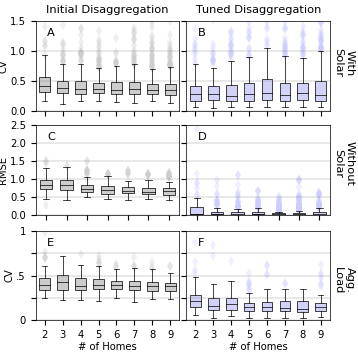

<IPython.core.display.Javascript object>


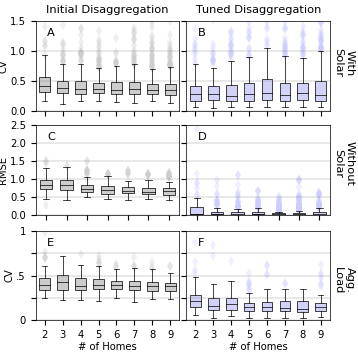

In [39]:
## Create figure for sensitivity to number of homes included
fig = sens_boxplotfig(scen_name = 'home',
    col_name = 'N_sys',
    x_label = '# of Homes'
    )


fig.savefig('figures/sens_' + 'N_prox' + '.pdf')


fig.savefig('figures/sens_Nhomes.pdf')
fig


<IPython.core.display.Javascript object>


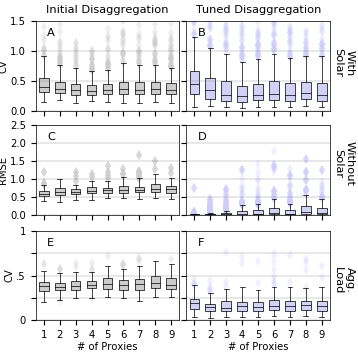

In [40]:
## Create figure for sensitivity to number of homes included
fig = sens_boxplotfig(scen_name = 'prox',
    col_name = 'N_prox_corrected',
    x_label = '# of Proxies'
    )


fig.savefig('figures/sens_' + 'N_prox' + '.pdf')


<IPython.core.display.Javascript object>


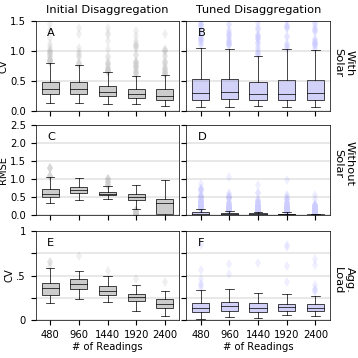

In [41]:
fig = sens_boxplotfig(scen_name = 'days',
    col_name = 'N_read',
    x_label = '# of Readings'
    )

fig.savefig('figures/sens_' + 'N_read' + '.pdf')


<IPython.core.display.Javascript object>


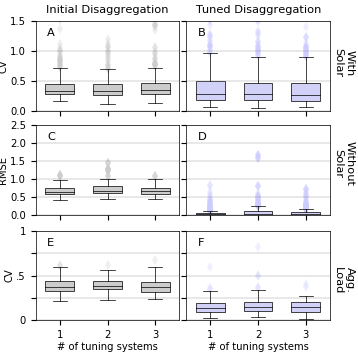

In [42]:
## Create figure for sensitivity to number of homes included
fig = sens_boxplotfig(scen_name = 'tune',
    col_name = 'N_tunesys',
    x_label = '# of tuning systems'
    )


fig.savefig('figures/sens_' + 'N_tunesys' + '.pdf')


## Load data for real time disaggregation

In [46]:
scenario_df = pd.read_csv('data/ScenarioAttmempt_streaming2.csv')
scenario_df['frac_reverse_bin'] = pd.cut(scenario_df['frac_reverse'],np.arange(0,.4, step = .025))
scenario_df['cv'] = np.abs(scenario_df['cv_pos'])
scenario_df['issolar'] = (scenario_df['models'] != 'AggregateLoad') & (scenario_df['mean'] < 0)


## Correct for the N_prox column for aggregate load. 
correct_prox = scenario_df[['scen_name','N_prox']][scenario_df['N_prox']>0].drop_duplicates()
correct_prox.columns = ['scen_name','N_prox_corrected']
scenario_df = scenario_df.merge(correct_prox)

scenario_df['plotkey'] = 'untuned'
scenario_df.loc[scenario_df['tuned'] & ~scenario_df['streaming'], 'plotkey'] = 'Train.'
scenario_df.loc[scenario_df['tuned'] & scenario_df['streaming'] & ~scenario_df['testdata'], 'plotkey'] = 'Stream,\nTrain.\nData'
scenario_df.loc[scenario_df['tuned'] & scenario_df['streaming'] & scenario_df['testdata'], 'plotkey']  = 'Stream,\nTest\nData'

scenario_df[['models','issolar','plotkey']].head(30)


models  issolar                plotkey
0      solar_5129     True                untuned
1      solar_8829     True                untuned
2   AggregateLoad    False                untuned
3      solar_5921    False                untuned
4        solar_93    False                untuned
5      solar_8645     True                untuned
6      solar_3039    False                untuned
7      solar_2814     True                untuned
8      solar_4514    False                untuned
9      solar_5129     True                 Train.
10     solar_8829     True                 Train.
11  AggregateLoad    False                 Train.
12     solar_5921    False                 Train.
13       solar_93    False                 Train.
14     solar_8645     True                 Train.
15     solar_3039    False                 Train.
16     solar_2814     True                 Train.
17     solar_4514    False                 Train.
18     solar_5129     True  Stream,\nTrain.\nData
19     solar_8829     True  Stream,\nTrain.\nData
20  AggregateLoad    False  Stream,\nTrain.\nData
21     solar_5921    False  Stream,\nTrain.\nData
22       solar_93    False  Stream,\nTrain.\nData
23     solar_8645     True  Stream,\nTrain.\nData
24     solar_3039    False  Stream,\nTrain.\nData
25     solar_2814     True  Stream,\nTrain.\nData
26     solar_4514    False  Stream,\nTrain.\nData
27     solar_5129     True    Stream,\nTest\nData
28     solar_8829     True    Stream,\nTest\nData
29  AggregateLoad    False    Stream,\nTest\nData

<IPython.core.display.Javascript object>


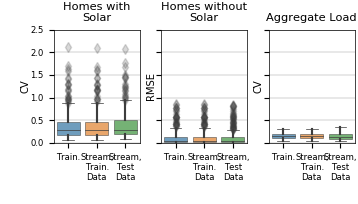

In [47]:
fig = plt.figure(figsize = (3.5,2))
plt.rc('xtick', labelsize = 6)
plt.rc('ytick', labelsize = 6)
plt.rc('axes', labelsize = 8)


## ******************************************
## Homes with Solar
ind = ((scenario_df['plotkey'] != 'untuned') & 
       (scenario_df['issolar']) & 
       (scenario_df['models'] != 'AggregateLoad') 
        )

plot_df = scenario_df.loc[ind,:]

ax = plt.axes([.15, .3, .24, .55])

sns.boxplot(ax = ax, data = plot_df, x = 'plotkey', y = 'cv',
           boxprops = {'lw':.5, 'alpha':.7},
           capprops = {'lw':.5},
           medianprops = {'lw':.5},
           flierprops = {'alpha':.2})
ax.set_title('Homes with\nSolar', fontsize = 8)
ax.set_ylim(0,2.5)
ax.set_xlabel('')
ax.set_ylabel('CV', labelpad=0, fontsize = 7)

## ******************************************
## Homes without Solar
ind = ((scenario_df['plotkey'] != 'untuned') & 
       (~scenario_df['issolar']) & 
       (scenario_df['models'] != 'AggregateLoad') 
        )

plot_df = scenario_df.loc[ind,:]

ax = plt.axes([.45, .3, .24, .55])

sns.boxplot(ax = ax, data = plot_df, x = 'plotkey', y = 'rmse',
           boxprops = {'lw':.5, 'alpha':.7},
           capprops = {'lw':.5},
           medianprops = {'lw':.5},
           flierprops = {'alpha':.2})

ax.set_title('Homes without\nSolar', fontsize = 8)
ax.set_ylim(0,2.5)
ax.set_ylabel('RMSE', labelpad=-3, fontsize = 7)
ax.set_xlabel('')
ax.set_yticklabels(['']*len(ax.get_yticks()))

## ******************************************
## Homes with Solar
ind = ((scenario_df['plotkey'] != 'untuned') & 
       (scenario_df['models'] == 'AggregateLoad') 
        )

plot_df = scenario_df.loc[ind,:]

ax = plt.axes([.75, .3, .24, .55])

sns.boxplot(ax = ax, data = plot_df, x = 'plotkey', y = 'cv',
           boxprops = {'lw':.5, 'alpha':.7},
           capprops = {'lw':.5},
           medianprops = {'lw':.5},
           flierprops = {'alpha':.2})
ax.set_ylabel('CV', labelpad=-3, fontsize = 7)
ax.set_title('Aggregate Load', size= 8)
ax.set_ylim(0,2.5)
ax.set_xlabel('')
ax.set_yticklabels(['']*len(ax.get_yticks()))

fig.savefig('realtime_results.png', dpi = 600)